In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import random

# open csv

In [33]:
# open preprocessed data
df = pd.read_csv('data/processed_reviews.csv')
without_dupe = df.drop_duplicates(subset=['review_text'], inplace=False)
# select subcategory to analyze
subcategory = 'SPRAY CLEANERS BLEACH CLEANERS'
label = "spray"
df = df[df['subcategory'] == subcategory]
print(df.shape)
df.head()

(4731, 10)


,brand,product_title,proxy_date,retailer,category,subcategory,review_text,star_rating,topic,brand_type
11,Clorox,Clorox Clean-Up All Purpose Cleaner with Bleac...,2024-07-01,Costco,CLEANING,SPRAY CLEANERS BLEACH CLEANERS,it do the work that be enough for me,5.0,Finding the Perfect Product,Clorox
12,Clorox,Clorox Clean-Up All Purpose Cleaner with Bleac...,2024-07-01,Costco,CLEANING,SPRAY CLEANERS BLEACH CLEANERS,i use it in the restroom and in the kitchen fo...,5.0,Disinfectant spray recommendations and reviews...,Clorox
16,CVS Total Home,"Total Home Cleaner With Bleach, 32 OZ",2024-07-01,CVS,CLEANING,SPRAY CLEANERS BLEACH CLEANERS,i use this in my shower that have pink mold an...,5.0,Effective products for mold and mildew removal...,Competitor
69,Clorox,Clorox® Clean-Up® Cleaner + Bleach1 Value Pack...,2024-07-01,Amazon,CLEANING,SPRAY CLEANERS BLEACH CLEANERS,i appreciate the value you get with this 3pack...,5.0,Disinfectant spray recommendations and reviews...,Clorox
116,Clorox,Clorox Clean-Up All Purpose Cleaner with Bleac...,2024-07-01,Target,CLEANING,SPRAY CLEANERS BLEACH CLEANERS,stay at a beach condo for several month last y...,5.0,Bathroom cleaning solutions,Clorox


In [34]:
# group reviews by subcategory and make dictrionary with rating: review_text
grouped = df.groupby('star_rating').apply(lambda x: x['review_text'].tolist()).to_dict()

/var/folders/x2/lsyflj4j07jc1sb3w3hfgmjc0000gn/T/ipykernel_43107/719716116.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('star_rating').apply(lambda x: x['review_text'].tolist()).to_dict()


# LSA

In [35]:
# create lsa pipeline
def create_components(n_topics):
    vectorizer = TfidfVectorizer(stop_words='english', 
                                 use_idf=True, 
                                 ngram_range=(1, 3),
                                 smooth_idf=True)
    svd_model = TruncatedSVD(n_components=n_topics,        
                             algorithm='randomized',
                             n_iter=20)
    return vectorizer, svd_model

In [61]:
# for each rating, fit the pipeline to the reviews and save results to lsa_df with columns: rating, topic_number, top_words, sample_reviews
lsa_df = pd.DataFrame(columns=['star_rating', 'review_text', 'lsa_topic_number', 'lsa_topic_words',])
rating_topics = {} # dictionary to store topic vectors for each rating
rating_topics_top_words = {} # dictionary to store top words for each topic for each rating
topics_per_rating = {1: ''}
for rating, reviews in grouped.items():
    n_topics = int(min(3, len(reviews)))
    # if n_topics >= 2:
    vectorizer, svd_model = create_components(n_topics)
    X_tfidf = vectorizer.fit_transform(reviews)
    topic_matrix = svd_model.fit_transform(X_tfidf)
    terms = vectorizer.get_feature_names_out()

    topic_vectors = svd_model.components_
    rating_topics[rating] = topic_vectors
    # Get the top words for each topic
    topic_words = {}
    for i in range(n_topics):
        top_word_indices = np.argsort(topic_vectors[i])[-15:]  # Top 10 words per topic
        top_words = [terms[idx] for idx in top_word_indices]
        topic_words[i] = top_words
    rating_topics_top_words[rating] = topic_words
    # For each review in the group, assign the most representative topic and top words
    for j, review in enumerate(reviews):
        most_representative_topic = np.argmax(topic_matrix[j])
        new_row = pd.DataFrame({
            'star_rating': [rating],
            'review_text': [review],
            'lsa_topic_number': [most_representative_topic],
            'lsa_topic_words': [', '.join(topic_words[most_representative_topic])]
        })
        lsa_df = pd.concat([lsa_df, new_row], ignore_index=True)

lsa_df

/var/folders/x2/lsyflj4j07jc1sb3w3hfgmjc0000gn/T/ipykernel_43107/1356449114.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  lsa_df = pd.concat([lsa_df, new_row], ignore_index=True)


,star_rating,review_text,lsa_topic_number,lsa_topic_words
0,1.0,my first time attempt to order this buster all...,2,"receive charge, complete, complete order, didn..."
1,1.0,one bottle leak out into the box toss the enti...,0,"damage leak, time, item, work, arrive, bottle ..."
2,1.0,usually i like these product but the item spil...,0,"damage leak, time, item, work, arrive, bottle ..."
3,1.0,receive spilling in my bag,2,"receive charge, complete, complete order, didn..."
4,1.0,package be receive in a home depot box with ob...,0,"damage leak, time, item, work, arrive, bottle ..."
...,...,...,...,...
4726,5.0,i be introduce to fantastik by my mother many ...,0,"like, spray, kitchen, good, cleaner, bleach, w..."
4727,5.0,this one be best one to clean dirty in your ho...,0,"like, spray, kitchen, good, cleaner, bleach, w..."
4728,5.0,work great for stubborn stain have a strong sc...,0,"like, spray, kitchen, good, cleaner, bleach, w..."
4729,5.0,i usually try to stay away from chemical howev...,0,"like, spray, kitchen, good, cleaner, bleach, w..."


In [62]:
rating_topics_top_words

{1.0: {0: ['damage leak',
   'time',
   'item',
   'work',
   'arrive',
   'bottle leak',
   'clorox',
   'order',
   'damage',
   'spray',
   'box',
   'product',
   'bleach',
   'leak',
   'bottle'],
  1: ['leak arrive',
   'bottle leak arrive',
   'leak box',
   'box',
   'product arrive damage',
   'leak return',
   'return',
   'product arrive',
   'bottle leak',
   'arrive damage',
   'arrive damage leak',
   'arrive',
   'damage',
   'damage leak',
   'leak'],
  2: ['receive charge',
   'complete',
   'complete order',
   'didnt complete order',
   'didnt complete',
   'charge',
   'refund',
   'damage',
   'item',
   'miss',
   'miss order',
   'didnt',
   'receive order',
   'receive',
   'order']},
 2.0: {0: ['buy bottle',
   'arrive',
   'bleach',
   'spray',
   'sprayer work',
   'buy',
   'sprayer',
   'product',
   'work',
   'bottle leak',
   'bottle leak box',
   'leak box',
   'box',
   'bottle',
   'leak'],
  1: ['use',
   'little',
   'stuff',
   'stop',
   'trigger'

In [63]:
# save lsa_df to csv
lsa_df.to_csv(f'outputs/lsa_{label}_prompt2_3_topics_per_rating.csv', index=False)
lsa_df.shape

(4731, 4)

# generate phrases for each topic

In [64]:
import os
from groq import Groq 

# Initialize the client
client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

# Define the system message
system_message = """
Generate a concise and coherent phrase that summarizes topics based on provided keywords
and associated review ratings. The keywords are ordered by relevance from the most to the least.

Ensure that each phrase accurately reflects the sentiment implied by the rating and highlights key aspects of the topic. 
For example, a rating of 1 should convey dissatisfaction or issues, while a rating of 5 should express satisfaction or positive feedback. 
Omit pronouns and conjunctions to keep the phrase succinct.

For reviews with low ratings (1-2) or with negative keywords, focus on problematic aspects such as defects, damages, or poor quality and 
be as detailed as possible.

Output only the phrase without additional commentary.

Example:

Input: "leak box, return, item, bottle leak, arrive damage, box, arrive, damage leak, damage, leak" Rating: 1
Output: "Leaking or damaged items and boxes upon delivery"
"""

def process_input(top_words, rating):
    user_message = f'Input: "{top_words}" rating: {rating}'
    response = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": system_message
            },
            {
                "role": "user",
                "content": user_message
            }
        ],
        model="llama3-8b-8192",
    )
    generated_phrase = response.choices[0].message.content
    return generated_phrase

topic_phrases = pd.DataFrame(columns=['star_rating', 'lsa_topic_number', 'lsa_topic_words', 'lsa_topic'])
# generate phrases for each topic in rating_topics_top_words
for rating, topics in rating_topics_top_words.items():
    for topic, top_words in topics.items():
        top_words = ', '.join(top_words)
        result = process_input(top_words, rating)
        new_row = pd.DataFrame({
            'star_rating': [rating],
            'lsa_topic_number': [topic],
            'lsa_topic_words': [top_words],
            'lsa_topic': [result]
        })
        topic_phrases = pd.concat([topic_phrases, new_row], ignore_index=True)
        print(f"Rating: {rating}, Topic: {topic}, Top Words: {top_words}")
        print(f"Generated phrase: {result}")
        print()

/var/folders/x2/lsyflj4j07jc1sb3w3hfgmjc0000gn/T/ipykernel_43107/3314073776.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  topic_phrases = pd.concat([topic_phrases, new_row], ignore_index=True)


Rating: 1.0, Topic: 0, Top Words: damage leak, time, item, work, arrive, bottle leak, clorox, order, damage, spray, box, product, bleach, leak, bottle
Generated phrase: "Leaking bottles damaged in delivery, defective product arriving"

Rating: 1.0, Topic: 1, Top Words: leak arrive, bottle leak arrive, leak box, box, product arrive damage, leak return, return, product arrive, bottle leak, arrive damage, arrive damage leak, arrive, damage, damage leak, leak
Generated phrase: "Leaking or damaged items and boxes upon delivery, poor packaging and quality control"

Rating: 1.0, Topic: 2, Top Words: receive charge, complete, complete order, didnt complete order, didnt complete, charge, refund, damage, item, miss, miss order, didnt, receive order, receive, order
Generated phrase: "Charges made without completing orders, causing damages and missed items"

Rating: 2.0, Topic: 0, Top Words: buy bottle, arrive, bleach, spray, sprayer work, buy, sprayer, product, work, bottle leak, bottle leak box,

In [65]:
# join with lsa_df
final_df = lsa_df.merge(topic_phrases, on=['star_rating', 'lsa_topic_number', 'lsa_topic_words'])

In [66]:
# save lsa_df to csv
final_df.to_csv(f'outputs/lsa_{label}_prompt2_3_topics_per_rating.csv', index=False)

In [80]:
final_df.groupby(['star_rating', 'lsa_topic_number']).size()

star_rating  lsa_topic_number
1.0          0                    229
             1                     15
             2                     28
2.0          0                     86
             1                     11
3.0          0                    116
             1                     35
             2                     14
4.0          0                    326
             1                     29
             2                     65
5.0          0                   3506
             1                     39
             2                    232
dtype: int64

## view generated phrases

In [67]:
topic_phrases

,star_rating,lsa_topic_number,lsa_topic_words,lsa_topic
0,1.0,0,"damage leak, time, item, work, arrive, bottle ...","""Leaking bottles damaged in delivery, defectiv..."
1,1.0,1,"leak arrive, bottle leak arrive, leak box, box...","""Leaking or damaged items and boxes upon deliv..."
2,1.0,2,"receive charge, complete, complete order, didn...","""Charges made without completing orders, causi..."
3,2.0,0,"buy bottle, arrive, bleach, spray, sprayer wor...","""Lining or leaking bottles and defective spray..."
4,2.0,1,"use, little, stuff, stop, trigger, buy spray, ...","""Defective sprayer and limited workability"""
5,2.0,2,"bottle half leak, liquid leak, liquid, buy bot...","""Leaky bottles arrive with liquids not inspected"""
6,3.0,0,"great, clorox, box, sprayer, like, good, work,...","""Effective cleaning with a good sprayer and de..."
7,3.0,1,"power, smell power, bathroom, leave, clean gre...","""Clean bathroom with strong but tolerable powe..."
8,3.0,2,"product long time, use product, stop work, pro...","""Sprayer leak issues hinder long-term use of s..."
9,4.0,0,"clorox, cleaner, spray, like, strong, good pro...","""Effective and strong Clorox cleaner for bathr..."


In [68]:
# sample reviews and print generated phrases
for rating in final_df['star_rating'].unique():
    if rating > 3:
        break
    print(f"Rating: {rating}")
    for i, row in final_df[final_df['star_rating'] == rating].sample(5).iterrows():
        print(f"Topic: {row['lsa_topic_number']}, Top Words: {row['lsa_topic_words']}")
        print(f"Review: {row['review_text']}")
        print(f"Generated phrase: {row['lsa_topic']}")
        print()

Rating: 1.0
Topic: 1, Top Words: leak arrive, bottle leak arrive, leak box, box, product arrive damage, leak return, return, product arrive, bottle leak, arrive damage, arrive damage leak, arrive, damage, damage leak, leak
Review: most of what be select have already expire
Generated phrase: "Leaking or damaged items and boxes upon delivery, poor packaging and quality control"

Topic: 0, Top Words: damage leak, time, item, work, arrive, bottle leak, clorox, order, damage, spray, box, product, bleach, leak, bottle
Review: be careful the product be inside a box quite big than the product and nothing contain it move it like if it be cristal cause its bleach and you dont wont your clothes to get damage like happen to me
Generated phrase: "Leaking bottles damaged in delivery, defective product arriving"

Topic: 0, Top Words: damage leak, time, item, work, arrive, bottle leak, clorox, order, damage, spray, box, product, bleach, leak, bottle
Review: with no date code on the bottle triple check

## distribution of topics for each rating

,star_rating,review_text,lsa_topic_number,lsa_topic_words,lsa_topic
0,1.0,my first time attempt to order this buster all...,2,"receive charge, complete, complete order, didn...","""Charges made without completing orders, causi..."
1,1.0,one bottle leak out into the box toss the enti...,0,"damage leak, time, item, work, arrive, bottle ...","""Leaking bottles damaged in delivery, defectiv..."
2,1.0,usually i like these product but the item spil...,0,"damage leak, time, item, work, arrive, bottle ...","""Leaking bottles damaged in delivery, defectiv..."
3,1.0,receive spilling in my bag,2,"receive charge, complete, complete order, didn...","""Charges made without completing orders, causi..."
4,1.0,package be receive in a home depot box with ob...,0,"damage leak, time, item, work, arrive, bottle ...","""Leaking bottles damaged in delivery, defectiv..."


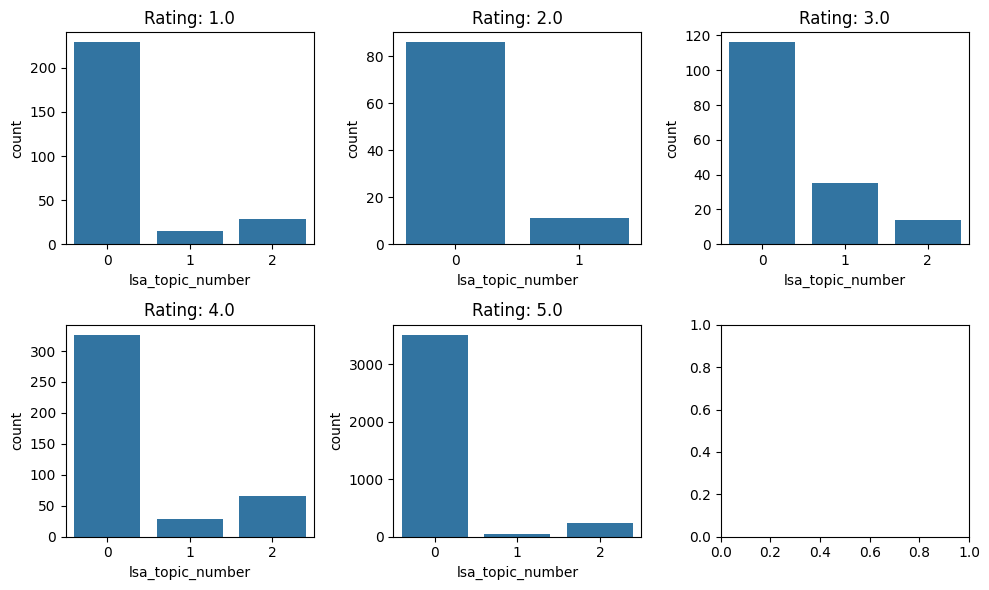

In [69]:
# visualize distribution of topics, one plot per rating arranged in grid with 2 rows and 3 columns
import seaborn as sns
import matplotlib.pyplot as plt

# create grid of plots
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

for rating in final_df['star_rating'].unique():
    row = int((rating - 1) // 3)
    col = int((rating - 1) % 3)
    ax = axs[row][col]
    sns.countplot(data=final_df[final_df['star_rating'] == rating], x='lsa_topic_number', ax=ax)
    ax.set_title(f"Rating: {rating}")

# Display all subplots together
plt.tight_layout()
plt.show()

# evaluate quality of generated phrases

In [48]:
final_df = pd.read_csv('outputs/lsa_spray_prompt2_3_topics_per_rating.csv')
final_df.head()

,star_rating,review_text,lsa_topic_number,lsa_topic_words,lsa_topic
0,1.0,my first time attempt to order this buster all...,2,"receive charge, complete, complete order, didn...","""Failed to complete orders with missed items a..."
1,1.0,one bottle leak out into the box toss the enti...,0,"damage leak, time, item, work, arrive, bottle ...","""Damaged leaky bottles and boxes in multiple o..."
2,1.0,usually i like these product but the item spil...,0,"damage leak, time, item, work, arrive, bottle ...","""Damaged leaky bottles and boxes in multiple o..."
3,1.0,receive spilling in my bag,2,"receive charge, complete, complete order, didn...","""Failed to complete orders with missed items a..."
4,1.0,package be receive in a home depot box with ob...,0,"damage leak, time, item, work, arrive, bottle ...","""Damaged leaky bottles and boxes in multiple o..."


In [49]:
# sample 100 from each rating/topic
sampled = final_df.groupby(['star_rating', 'lsa_topic_number']).apply(lambda x: x.sample(min(len(x), 50))).reset_index(drop=True)
len(sampled)

/var/folders/x2/lsyflj4j07jc1sb3w3hfgmjc0000gn/T/ipykernel_43107/4282243335.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = final_df.groupby(['star_rating', 'lsa_topic_number']).apply(lambda x: x.sample(min(len(x), 50))).reset_index(drop=True)


521

In [50]:
# use sentence transformers to get similarity score between reviews and generated phrases
from sentence_transformers import SentenceTransformer
from torch.nn.functional import cosine_similarity

def similarity_scores(model_name, df):
    model = SentenceTransformer(model_name)
    reviews = df['review_text'].tolist()
    phrases = df['lsa_topic'].tolist()
    review_embeddings = model.encode(reviews, convert_to_tensor=True)
    phrase_embeddings = model.encode(phrases, convert_to_tensor=True)
    similarity_scores = cosine_similarity(review_embeddings, phrase_embeddings).cpu().numpy()
    return similarity_scores


In [51]:
import time
models = {'all-MiniLM-L6-v2': 'miniLM', 'all-mpnet-base-v2': 'mpnet', 'all-distilroberta-v1': 'distilroberta'}
for model_name, model_label in models.items():
    start = time.time()
    scores = similarity_scores(model_name, sampled)
    end = time.time()
    print(f"Time taken for {model_label}: {end - start}")
    sampled[model_label] = scores

/Users/jessicaluo/Desktop/scrap/text_processes/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Time taken for miniLM: 6.495076894760132


/Users/jessicaluo/Desktop/scrap/text_processes/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Time taken for mpnet: 18.901129961013794


/Users/jessicaluo/Desktop/scrap/text_processes/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Time taken for distilroberta: 9.87671709060669


In [52]:
# take average of similarity scores and add to new column
sampled['average_similarity_score'] = sampled[['miniLM', 'mpnet', 'distilroberta']].mean(axis=1)
sampled.sample(5)

,star_rating,review_text,lsa_topic_number,lsa_topic_words,lsa_topic,miniLM,mpnet,distilroberta,average_similarity_score
92,1.0,i dont believe that this be include in my orde...,2,"receive charge, complete, complete order, didn...","""Failed to complete orders with missed items a...",0.342434,0.233268,0.306431,0.294044
372,4.0,love the product but would reconsider buy liqu...,2,"refill spray, refill spray bottle, love, nozzl...","""Satisfying refill spray bottle experience wit...",0.322119,0.380851,0.357306,0.353425
192,3.0,terrible package the label be wash off the pro...,0,"great, clorox, box, sprayer, like, good, work,...","""Effective cleaning and good smell, but occasi...",0.341757,0.417179,0.422433,0.393790
404,5.0,its amazing take stain off instantly,0,"like, spray, kitchen, good, cleaner, bleach, w...","""Effective kitchen and bathroom cleaner with g...",0.360609,0.365507,0.351910,0.359342
127,2.0,its a very strong bleach cleanser but it strip...,0,"buy bottle, arrive, bleach, spray, sprayer wor...","""Bottle leaks or sprayer issues with packaged ...",0.036272,0.159453,0.130156,0.108627


In [53]:
# save sampled evaluations to csv
sampled.to_csv('outputs/cos_similarity/sampled_spray_prompt2.csv', index=False)

### plot average similarity score for each topic in each rating

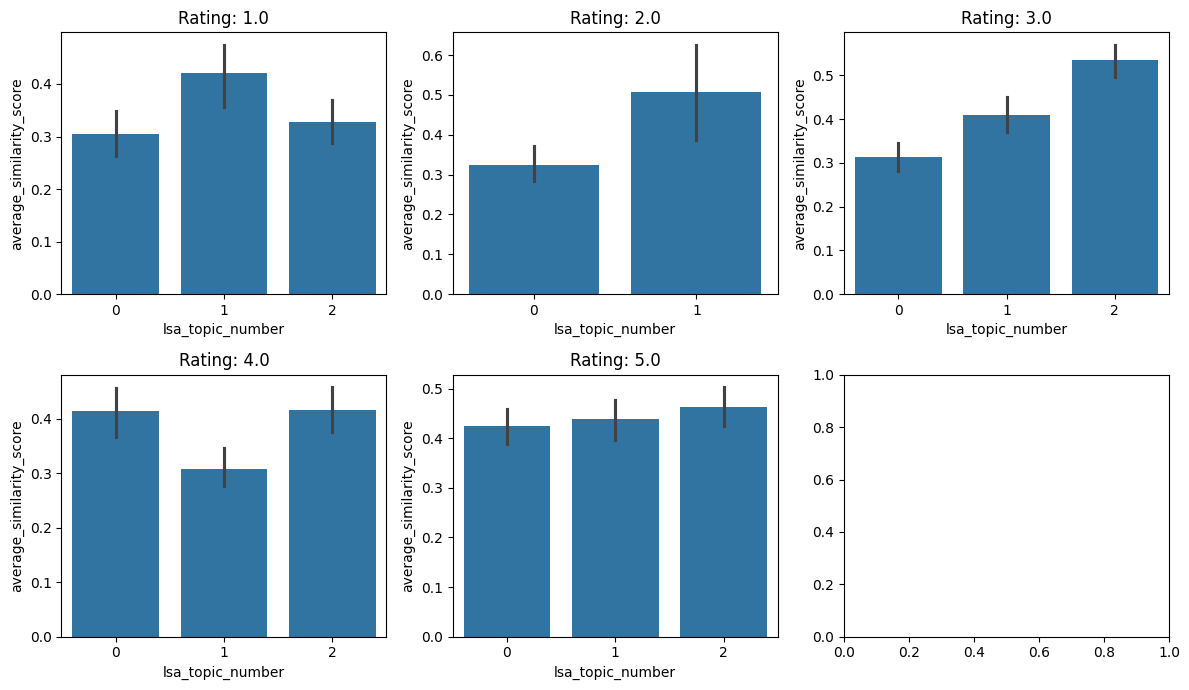

In [54]:
# visualize average similarity scores for each rating/topic
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

for rating in sampled['star_rating'].unique():
    row = int((rating - 1) // 3)
    col = int((rating - 1) % 3)
    ax = axs[row][col]
    sns.barplot(data=sampled[sampled['star_rating'] == rating], x='lsa_topic_number', y='average_similarity_score', ax=ax)
    ax.set_title(f"Rating: {rating}")
plt.tight_layout()

### plot histogram of average similarity score across all sampled reviews

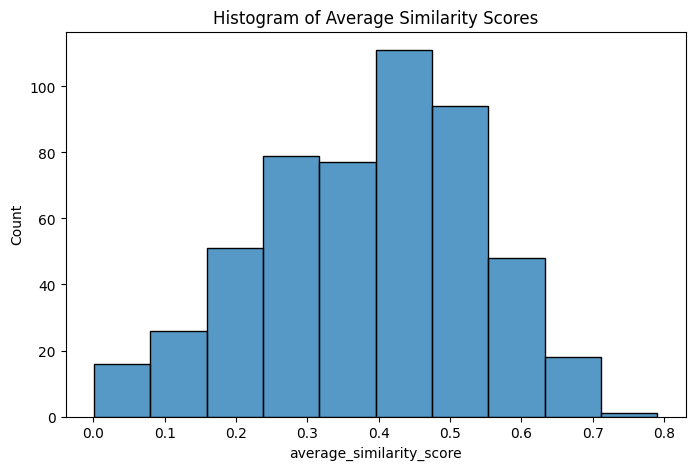

In [55]:
plt.figure(figsize=(8, 5))
sns.histplot(sampled['average_similarity_score'], bins=10)
plt.title("Histogram of Average Similarity Scores")
plt.show()

### plot a histograms of average similarity score for each rating

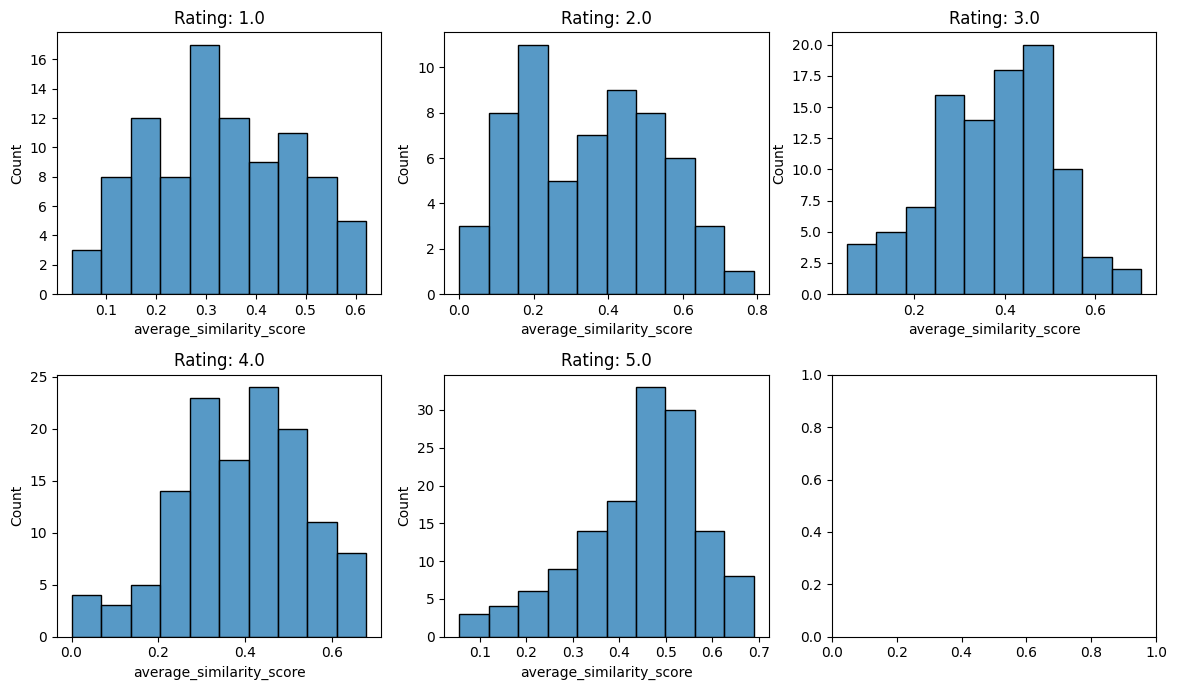

In [56]:
# plot a histograms of average similarity score for each rating using grid of plots
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

for rating in sampled['star_rating'].unique():
    row = int((rating - 1) // 3)
    col = int((rating - 1) % 3)
    ax = axs[row][col]
    sns.histplot(sampled[sampled['star_rating'] == rating]['average_similarity_score'], bins=10, ax=ax)
    ax.set_title(f"Rating: {rating}")
plt.tight_layout()

In [4]:
prompt1_df = pd.read_csv('outputs/lsa_1-2gram_3_topics_per_rating_5121.csv')
prompt1_df.head()

,star_rating,review_text,review_text_clean,lsa_topic_number,lsa_topic_words,lsa_topic
0,1.0,My First time attempting to order this buster ...,my first time attempt to order this buster all...,2,"charge, miss, receive item, spill, receive ord...","""Damaged or missed orders and poor customer se..."
1,1.0,"One bottle leaked out into the box, tossed the...",one bottle leak out into the box toss the enti...,0,"damage, bottle leak, clorox, work, box, bleach...","""Bottle leak and poor product quality at deliv..."
2,1.0,"Usually, I like these products but the item sp...",usually i like these product but the item spil...,0,"damage, bottle leak, clorox, work, box, bleach...","""Bottle leak and poor product quality at deliv..."
3,1.0,Received spilling in my bag,receive spilling in my bag,2,"charge, miss, receive item, spill, receive ord...","""Damaged or missed orders and poor customer se..."
4,1.0,Package was received in a Home Depot box with ...,package be receive in a home depot box with ob...,0,"damage, bottle leak, clorox, work, box, bleach...","""Bottle leak and poor product quality at deliv..."


In [5]:
# sample 100 from each rating/topic
sampled_prompt1 = prompt1_df.groupby(['star_rating', 'lsa_topic_number']).apply(lambda x: x.sample(min(len(x), 50))).reset_index(drop=True)
len(sampled_prompt1)

/var/folders/x2/lsyflj4j07jc1sb3w3hfgmjc0000gn/T/ipykernel_43107/2205315920.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = prompt1_df.groupby(['star_rating', 'lsa_topic_number']).apply(lambda x: x.sample(min(len(x), 50))).reset_index(drop=True)


556

In [7]:
import time
models = {'all-MiniLM-L6-v2': 'miniLM', 'all-mpnet-base-v2': 'mpnet', 'all-distilroberta-v1': 'distilroberta'}
for model_name, model_label in models.items():
    start = time.time()
    scores = similarity_scores(model_name, sampled_prompt1)
    end = time.time()
    print(f"Time taken for {model_label}: {end - start}")
    sampled_prompt1[model_label] = scores

/Users/jessicaluo/Desktop/scrap/text_processes/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Time taken for miniLM: 16.39395785331726


/Users/jessicaluo/Desktop/scrap/text_processes/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Time taken for mpnet: 23.756603240966797


/Users/jessicaluo/Desktop/scrap/text_processes/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Time taken for distilroberta: 13.502617120742798


In [8]:
# take average of similarity scores and add to new column
sampled_prompt1['average_similarity_score'] = sampled_prompt1[['miniLM', 'mpnet', 'distilroberta']].mean(axis=1)
sampled_prompt1.sample(5)

,star_rating,review_text,review_text_clean,lsa_topic_number,lsa_topic_words,lsa_topic,miniLM,mpnet,distilroberta,average_similarity_score
362,4.0,name brand does what it says it should do,name brand do what it say it should do,2,"nozzle, cleanup, clorox spray, buy, product, r...","""Effective nozzle for easy cleanup""",0.188734,0.352899,0.347997,0.296543
500,5.0,works great! I purchased this with a grocery d...,work great i purchase this with a grocery deli...,1,"good, price, job, cleaning, product work, grea...","""Effective and affordable cleaning product""",0.331383,0.424393,0.405338,0.387038
385,4.0,i love how well this cleans but we have gotten...,i love how well this clean but we have get som...,2,"nozzle, cleanup, clorox spray, buy, product, r...","""Effective nozzle for easy cleanup""",0.472382,0.514448,0.511304,0.499378
331,4.0,Good cleaning item. But it leaks,good cleaning item but it leak,1,"spray bottle, work, good buy, bottle, product ...","""Good product with occasional leak issues""",0.585943,0.610853,0.594775,0.597190
497,5.0,This product works quickly. It is great for th...,this product work quickly it be great for thos...,1,"good, price, job, cleaning, product work, grea...","""Effective and affordable cleaning product""",0.253277,0.360869,0.402990,0.339045


In [23]:
# save sampled evaluations to csv
sampled_prompt1.to_csv('outputs/cos_similarity/sampled_spray_prompt1.csv', index=False)

In [24]:
# get average similarity score for each rating/topic
avg_similarity1 = sampled_prompt1.groupby(['star_rating', 'lsa_topic_number'])['average_similarity_score'].mean().reset_index()
avg_similarity1

,star_rating,lsa_topic_number,average_similarity_score
0,1.0,0,0.390091
1,1.0,1,0.431182
2,1.0,2,0.234482
3,2.0,0,0.251403
4,2.0,1,0.508965
5,2.0,2,0.413472
6,3.0,0,0.379615
7,3.0,1,0.380109
8,3.0,2,0.384306
9,4.0,0,0.411841


In [57]:
avg_similarity2 = sampled.groupby(['star_rating', 'lsa_topic_number'])['average_similarity_score'].mean().reset_index()
avg_similarity2

,star_rating,lsa_topic_number,average_similarity_score
0,1.0,0,0.305260
1,1.0,1,0.420323
2,1.0,2,0.327471
3,2.0,0,0.325262
4,2.0,1,0.506658
5,3.0,0,0.312231
6,3.0,1,0.410405
7,3.0,2,0.534045
8,4.0,0,0.413973
9,4.0,1,0.307982


In [58]:
# calculate average score per rating
avg_similarity1.groupby('star_rating')['average_similarity_score'].mean()

star_rating
1.0    0.351918
2.0    0.391280
3.0    0.381344
4.0    0.364819
5.0    0.402690
Name: average_similarity_score, dtype: float32

In [59]:
avg_similarity2.groupby('star_rating')['average_similarity_score'].mean()

star_rating
1.0    0.351018
2.0    0.415960
3.0    0.418894
4.0    0.379112
5.0    0.442635
Name: average_similarity_score, dtype: float32

In [60]:
# find review with hghest average similarity score
sampled[sampled['average_similarity_score'] == sampled['average_similarity_score'].max()]

,star_rating,review_text,lsa_topic_number,lsa_topic_words,lsa_topic,miniLM,mpnet,distilroberta,average_similarity_score
149,2.0,i like this product but i have 2 here now with...,1,"use, little, stuff, stop, trigger, buy spray, ...","""Trigger-based sprayer defective, works poorly""",0.817587,0.814939,0.740409,0.790978
